# Advances in Machine Learning with Big Data

### (part 1 of 2) 
### Trinity 2020 Weeks 1 - 4
### Dr Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os
from mpl_toolkits.mplot3d import axes3d
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

import numpy as np  
import pandas as pd  

#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import model_selection

import sbs_sklearn    # module where I've put some functions from the last class
from uci_retail_data import uci_files, stock_codes

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_coeffs(mod, mod_name, comment):
    plt.plot(mod.coef_, marker='o')
    plt.grid()
    plt.title(f"The betas of the {mod_name} - {comment}")
    plt.axhline(color='k')

## 6. Decision trees, bagging, and random forests

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. Overfit and regularization

1. Regularization through predictor/feature selection (Lasso etc.)

1. Resampling methods, and model selection

1. **Decision trees, bagging, and random forests**

1. Single-layer neural networks

Load data per previous classes ...

In [3]:
df = uci_files.standard_uci_data_access()

2020-04-27 14:44:27,713 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2020-04-27 14:44:30,904 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [4]:
invalids = stock_codes.invalid_series(df)

In [5]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

Prepare our dataset for linear regression:

In [6]:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']

y = invoices.log_item_spend.reset_index(drop=True)
X = invoices[predictors].reset_index(drop=True)

In [7]:
from sklearn import preprocessing
poly = preprocessing.PolynomialFeatures(4)
polynomial_X = pd.DataFrame(poly.fit_transform(X.values))
polynomial_X.columns = poly.get_feature_names(X.columns)
del polynomial_X['1']

### Decision trees: a motivation

Recall in past classes we created a lot of dimensions of predictors from only 4 fundamental quantities:

In [8]:
poly_std_X = ((polynomial_X - polynomial_X.mean()) / polynomial_X.std())

In [9]:
X.shape

(20577, 4)

In [10]:
polynomial_X.shape

(20577, 69)

This was in order to facilitate a non-linear fit to our data.

Lets visualize the non-linearities we thereby enabled.

### Preparations for 3d plotting:

Config:

In [11]:
HOUR = 12
MONTH = 201007
PLM = polynomial_X.mean()
PLS = polynomial_X.std()

In [12]:
AX_MIN = 0
AX_MAX = 4
JUMPS = 20j

GRID_X, GRID_Y = np.mgrid[AX_MIN: AX_MAX: JUMPS, AX_MIN: AX_MAX: JUMPS]

Library:

In [13]:
def poly_prediction(l, w, predictor, polyn):
    """
    @param predictor: a method such as LinearModel().predict
    @param polyn: object of type sklearn.preprocessing.PolynomialFeatures
    for given l and w, we return the prediction from a polynomial regression
    """
    two_d_array = np.array((l, HOUR, MONTH, w))[None, :]
    poly_a = polyn.fit_transform(two_d_array).T
    return predictor([(poly_a[1:, 0] - PLM) / PLS])

In [14]:
def threeDplot(a, b, c, model_name='Decision Tree'):
    ax = plt.figure().add_subplot(111, projection="3d")
    ax.plot_surface(a, b, c, cmap="coolwarm", rstride=1, cstride=1)
    ax.set_title(f"Predictions of the {model_name}, setting hour to {HOUR} and month to {MONTH}")
    return ax

In [15]:
def set_todays_labels(axs):
    axs.set_xlabel(X.columns[0].strip("log_"))
    axs.set_ylabel(X.columns[-1])
    axs.set_zlabel(y.name.strip("log_"))

### First, lets use this technology to observe last class' `ElasticNetCV()`:

Create our learner:

In [16]:
elasticCV = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .75, .95])

Do a 25-fold split of the data:

In [17]:
N_FOLDS = 25
kfold = model_selection.KFold(n_splits=N_FOLDS, shuffle=True)

# we will train on only a random 1/25 of the data (and could test on the other 24/25):
test, train = next(kfold.split(poly_std_X, y))

Fit model:

In [18]:
elasticCV.fit(poly_std_X.loc[train], y.loc[train])
f"Cross Validation tunes alpha parameter to {elasticCV.alpha_ * (len(y) / N_FOLDS) * 2 :.2f}, whereas JL found 25 last class by guessing"

'Cross Validation tunes alpha parameter to 36.16, whereas JL found 25 last class by guessing'

A view of the fit of the Elastic Net (with Cross-Validation):

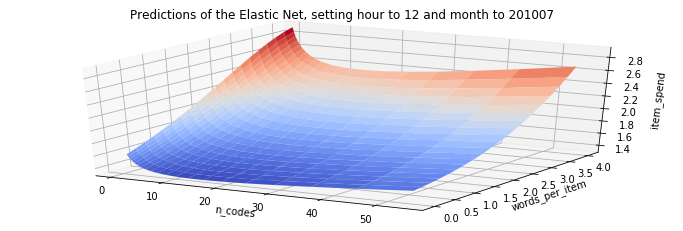

In [19]:
elastic_surface = np.vectorize(poly_prediction)(GRID_X, GRID_Y, elasticCV.predict, poly)

ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(elastic_surface), model_name = 'Elastic Net')
set_todays_labels(ax)

### Modelling-pipelines

We began with predictors, $X$:

 * we transformed $X$ into a 69-dimensional array of polynomial features
 * we standardized these features to be mean 0, variance 1
 * we fitted an Elastic Net, using Cross-Validation

The designers of `scikit-learn`, and other machine-learning packages, realised that this code begins to look unwieldy.

Alternative:

In [20]:
from sklearn.pipeline import make_pipeline

In [21]:
elasticCVpl = make_pipeline(preprocessing.PolynomialFeatures(include_bias=False, degree=4),
                            preprocessing.StandardScaler(),
                            linear_model.ElasticNetCV(l1_ratio=[.1, .5, .75, .95]))

In [22]:
elasticCVpl

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False,
                                    interaction_only=False, order='C')),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('elasticnetcv',
                 ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001,
                              fit_intercept=True,
                              l1_ratio=[0.1, 0.5, 0.75, 0.95], max_iter=1000,
                              n_alphas=100, n_jobs=None, normalize=False,
                              positive=False, precompute='auto',
                              random_state=None, selection='cyclic', tol=0.0001,
                              verbose=0))],
         verbose=False)

In [23]:
def prediction(l, w, predictor):
    two_d_array = np.array( [l, HOUR, MONTH, w] )[None, :]
    return predictor(two_d_array)

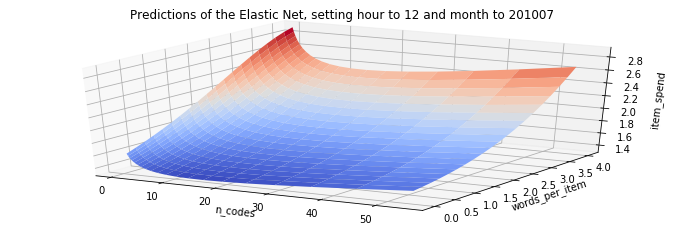

In [24]:
elasticCVpl.fit(X.loc[train], y.loc[train])

elastic_surface = np.vectorize(prediction)(GRID_X, GRID_Y, elasticCVpl.predict)

ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(elastic_surface), model_name = 'Elastic Net')
set_todays_labels(ax)

... bottom line: this is the same picture as above. Pipelines save lines of code and much aid understanding.

Signpost/analogy: [tensorflow.keras.Sequential()](https://www.tensorflow.org/guide/keras/overview#build_a_simple_modell)

### Decision tree in action:

Argument for tree methods: 

* actually the polynomial functions are in equal measures complicated, and restrictive
* plus, they may extend poorly outside the space where data has been observed

Let's dispense with that. In fact, we've got enough data just to **fit a step function** to this shape.

In [25]:
# lets import two new parts of scikit-learn
from sklearn import tree
from sklearn import ensemble

Fitting the tree: brief, and familiar, code:

In [26]:
dec_tree = tree.DecisionTreeRegressor(max_depth=2)
dec_tree.fit(X.loc[train], y.loc[train])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now we are ready to generate the surface:

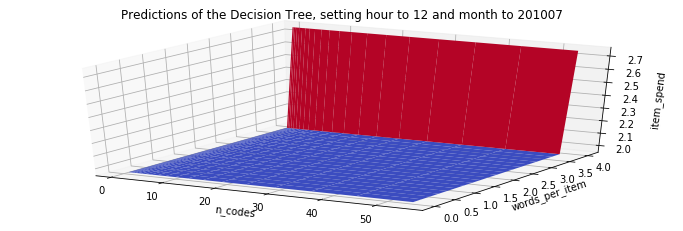

In [27]:
tree_surface = np.vectorize(prediction)(GRID_X, GRID_Y, dec_tree.predict)

ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(tree_surface))
set_todays_labels(ax)

Looks sensible-ish but preliminary.

Idea: use **tree** logic to build a sensible step function

* need to decide on the shape and size of each branch in the tree

Here's the same information as the graph above:

In [28]:
print(tree.export_text(dec_tree))

|--- feature_3 <= 3.85
|   |--- feature_0 <= 4.99
|   |   |--- value: [0.67]
|   |--- feature_0 >  4.99
|   |   |--- value: [1.42]
|--- feature_3 >  3.85
|   |--- feature_1 <= 16.50
|   |   |--- value: [1.01]
|   |--- feature_1 >  16.50
|   |   |--- value: [1.73]



Note: this tree has (by my count) ~10 parameters.

[Wikipedia visual illustration](https://en.wikipedia.org/wiki/Decision_tree_learning#/media/File:Cart_tree_kyphosis.png)

[scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

### Regression tree

*Introduction to Statistical Learning* Ch. 8

Recursive, binary, splitting
* top-down
* greedy

So, we
1. Select the predictor, $X_j$, and the cut-point $s$ leading to the partition that *most reduces* MSE (note that $s$ might as well be $X_{ji}$ for some $i$)

1. Apply this partition. Now repeat 1. for each side of the partition.

1. Repeat this `max_depth` many times.

1. Note the average value of the response in each partitioned area of the space.

The tree makes use only of the *ordinal* structure of the feature, not its cardinality. That's handy here, given the way we defined `month`.

OK, lets try a much bigger `max_depth`:

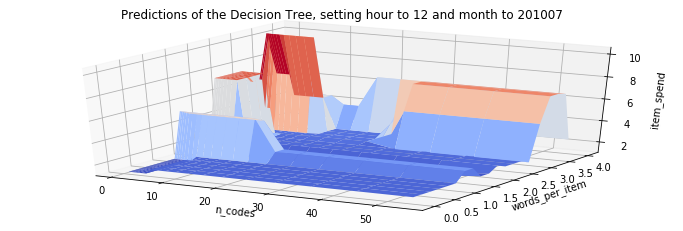

In [29]:
dec_tree_ten = tree.DecisionTreeRegressor(max_depth=10)
dec_tree_ten.fit(X.loc[train], y.loc[train])

tree_surface = np.vectorize(prediction)(GRID_X, GRID_Y, dec_tree_ten.predict)

ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(tree_surface))
set_todays_labels(ax)

Not brilliant once there are many levels of depth. How can we improve this?
* For one thing, we can use KFold Cross-Validation to select the best depth for the tree.
* A more refined approach considers *cost complexity pruning*.
* A pragmatic approach is to set `min_weight_fraction_leaf=0.1` ([here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)), or to some other sensible value

All these approaches are forms of regularizing.

Setting  `min_weight_fraction_leaf=0.1` ([here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)):

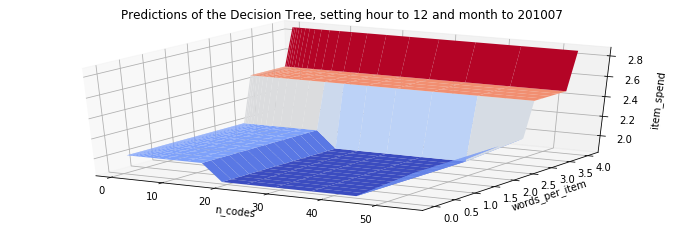

In [30]:
dec_tree_prag = tree.DecisionTreeRegressor(min_weight_fraction_leaf=0.1)
dec_tree_prag.fit(X.loc[train], y.loc[train])
tree_surface = np.vectorize(prediction)(GRID_X, GRID_Y, dec_tree_prag.predict)

ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(tree_surface))
set_todays_labels(ax)

We're getting a fairly sensible tree now, but still an uneasy sense that it is very dependent on the data we have.

Lets check how dependent this is on data: Next data, please:

In [31]:
test, train = next(kfold.split(poly_std_X, y))

Fit a new tree the same way - get something rather different:

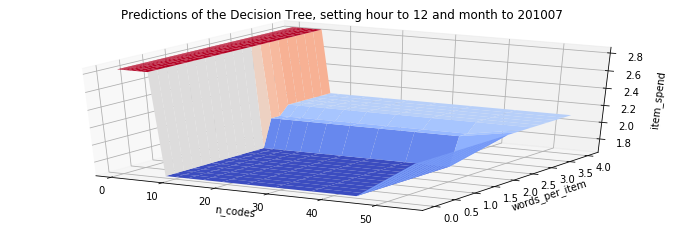

In [32]:
tri = tree.DecisionTreeRegressor(min_weight_fraction_leaf=0.1)
tri.fit(X.loc[train], y.loc[train])
surf = np.vectorize(prediction)(GRID_X, GRID_Y, tri.predict)
ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(surf))
set_todays_labels(ax)

This suggests, maybe it would be a good idea to take the average of all 25 K-fold training sets.

*Bagging* is the natural extension of this idea.

### Bagging = Bootstrap Aggregation

*Introduction to Statistical Learning* 8.2.1

Decision trees suffer from high variance - very sensitive to the kfold-split. Perhaps moreso than the Polynomial Regression.

So lets generate lots of them, and average (=aggregate) these.

Rather than from a K-fold split, we'll generate each decision tree from a bootstrap sample of our data.
* \> [bootstrap aggregation](https://en.wikipedia.org/wiki/Bootstrap_aggregating) > bagging

In principle, you could do bagging on any model. Among other models, it is rather useful on trees.

Why could aggregating many trees be a good idea? 
* Trees may be 'weak learners' with high variance, but suppose they are
   * unbiased
   * independent of each other
* Further suppose we had an 'indefinite production-line' which can create $M\rightarrow\infty$ such trees:

> then a Weak Law of Large Numbers will tell us that their average is consistent everywhere in the space of $x_i$.
   
There's a lot of 'supposing' going on here, yet it turns out that with ingenuity these suppositions can be made more reasonable ...

#### Bagging in action:

I can't disguise that we are nearly at the Random Forest. 

... for, scikit-learn sees a bag-of-trees as a special case of the Random Forest, with a certain option set: `max_features=len(X.columns)`

In [33]:
bag = ensemble.RandomForestRegressor(min_weight_fraction_leaf=0.1, max_features=len(X.columns))
bag.fit(X.loc[train], y.loc[train])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.1,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

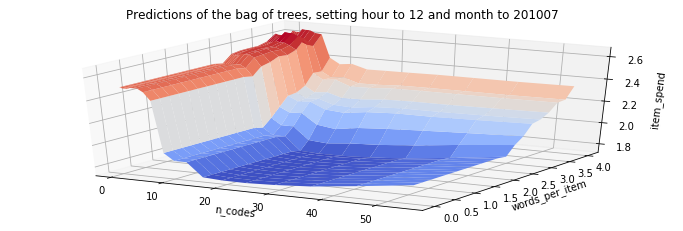

In [34]:
surf = np.vectorize(prediction)(GRID_X, GRID_Y, bag.predict)
ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(surf), model_name='bag of trees')
set_todays_labels(ax)

Note the randomness here - about which bootstrap samples we drew. 

If I reran the boxes above, I'd get different shapes.

### Numbers of parameters

Bag-of-trees: 100 trees, each with ~20 parameters - that's many more parameters than we may be used to - thousands!

* In the case of trees, at least these numerous parameters are generated using a concise set of rules.
* They are also encode/encapsulate some randomness (output of `numpy.random`).

**Traditional reaction** might have been: "This simply has far too many degrees of freedom".

Lets respond this way today: 
* "When you mention degrees of freedom, you allude to the penalty in AIC/BIC. 
* But as we saw, there are other, entirely different, ways of regularizing. 
* Today's compute power makes these alternatives entirely feasible. 
* They should be judged on their hold-out sample results, so lets take a look!
* Even if there are many parameters, the fitting algorithm itself was simple."

### Random Forest

The random forest is a bag-of-trees, generated using bagging. 

The bootstrap already introduced some randomness.

To get the random forest, we add a second source of randomness, designed to **decorrelate** the trees. 

This can be seen as a further form of regularization: the randomness hinders the fitting of the trees.

Specifically, each time we pick a cut, in order to branch the tree, we will consider a random subset of only $K$ of the predictors.

In code, we will set `max_features = K < len(X.columns)`. 

Small tweak to the bag-of-trees implementation:

In [35]:
random_forest = ensemble.RandomForestRegressor(min_weight_fraction_leaf=0.1, 
                                               max_features=int(np.sqrt(len(X.columns))))
random_forest.fit(X.loc[train], y.loc[train])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.1,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

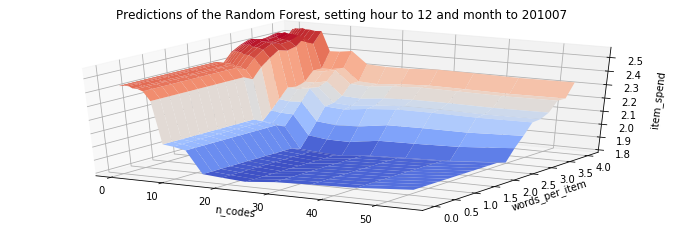

In [36]:
surf = np.vectorize(prediction)(GRID_X, GRID_Y, random_forest.predict)
ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(surf), model_name='Random Forest')
set_todays_labels(ax)

Why not try the Random Forest on our whole dataset?

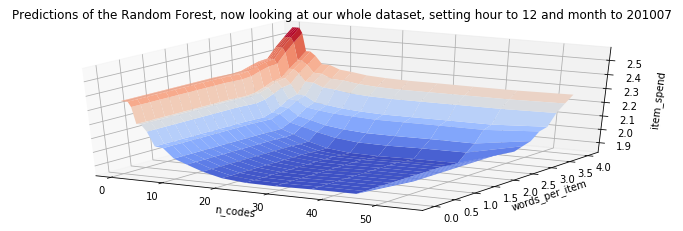

In [37]:
random_forest = ensemble.RandomForestRegressor(min_weight_fraction_leaf=0.1, 
                                               # this is actually the recommended default choice:
                                               max_features=int(np.sqrt(len(X.columns)))
                                              )
random_forest.fit(X, y)

surf = np.vectorize(prediction)(GRID_X, GRID_Y, random_forest.predict)
ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(surf), model_name='Random Forest, now looking at our whole dataset')
set_todays_labels(ax)

My favourite parameterization:

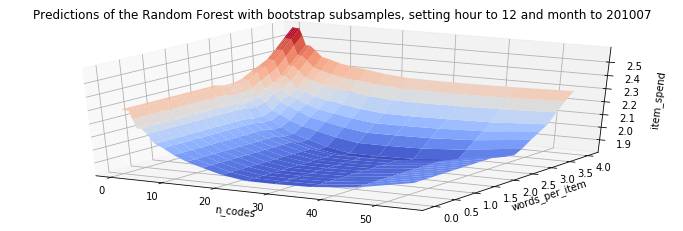

In [38]:
random_forest = ensemble.RandomForestRegressor(min_weight_fraction_leaf=0.1, 
                                               max_features=int(np.sqrt(len(X.columns))),  
                                               max_samples=1/25,   # each Bootstrap only takes account of 4% of the data
                                               n_estimators=500) # number of trees: up from 100 previously
random_forest.fit(X, y)

surf = np.vectorize(prediction)(GRID_X, GRID_Y, random_forest.predict)
ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(surf), model_name='Random Forest with bootstrap subsamples')
set_todays_labels(ax)

### Boosting in Regression problems

Note that boosting has had perhaps its best results outside regression, in classification: 
* According to Tibshirani 2013, Leo Breiman (the inventor of bagging!) once called boosting the "greatest off-the-shelf classifier in the world"

In regression, we can understand it as Gradient Boosting (in classification we find the famous AdaBoost)

If we value MSE, then Gradient Boosting has the formulation in *Introduction to Statistical Learning* 8.2.3, Algorithm 8.2

#### ISL Algorithm 8.2 *Boosting for regression trees*

1. Set $\hat f(x) = 0$ and $r_i = y_i$ for all $i$ in the the training set.

2. For $b=1, 2, 3, ... B$, repeat:
     1. Fit a tree with $d$ splits to the training data, $(X, r$), call it $\hat f^b(x)$
     1. Add to $\hat f$ by adding a version of the new tree, where it has been shrunk by a (small) factor $\lambda$.
     1. Update the residuals, $r_i$, taking account that  $\hat f$ is now  $\hat f + \lambda\hat f^b$

#### Comments:

In bagging, trees can be created in parallel, but in boosting they have to be created sequentially.

Each tree can focus on the shortcomings of its predecessors.

There's less emphasis on randomness here, but - as in bagging - it will be helpful to add some randomness.

Tuning parameters are 
* the number of trees we set out to build, $B$, 
* the small $\lambda > 0$, and 
* the choice of complexity of the tree, $d$.

As always, we can use cross-validation to tune. Often the best $d$ turns out to be less than in bagging and the best $\lambda$ turns out to be small.

In [39]:
from sklearn import ensemble

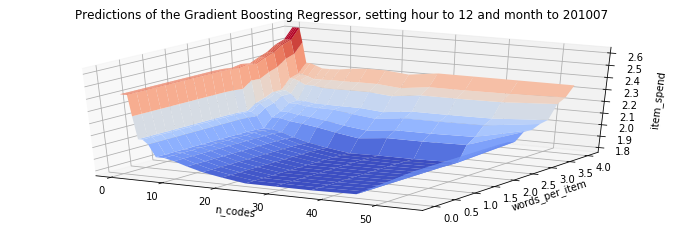

In [40]:
gradboost = ensemble.GradientBoostingRegressor(n_estimators=500,                # akin to d
                                               min_weight_fraction_leaf=0.1,    # this is B
                                               learning_rate=0.01)              # this is lambda
gradboost.fit(X, y)

surf = np.vectorize(prediction)(GRID_X, GRID_Y, gradboost.predict)
ax = threeDplot(a = np.exp(GRID_X), b = GRID_Y, c = np.exp(surf), model_name='Gradient Boosting Regressor')
set_todays_labels(ax)

**[Overview of various ensemble techniques in scikit-learn](https://scikit-learn.org/stable/modules/ensemble.html)**